<a href="https://colab.research.google.com/github/EnoiuDiana/Stroke-Predictor/blob/bori_dev/Stroke_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stroke Prediction based on medical and demographical data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Problem Statement

TODO: nice description of what we want to do, why this is relevant, etc.

## Setup

In [11]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
file_path = "https://drive.google.com/file/d/1x3Vu2Egi5LIvd0jkHnZKeBx-Ye0l8sTr/view?usp=sharing"
file_path ='https://drive.google.com/uc?id=' + file_path.split('/')[-2]
stroke_df = pd.read_csv(file_path)

In [4]:
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Initial Data Analysis

Goal: 
*   get to know our data
*   see how data should be cleaned
*   find interesting correlations
*   formulate a hypothesis

TODO: write a nice introduction before submitting the assignment :)

### Analysing the individual features

#### Gender

In [25]:
stroke_df.groupby('gender').size()
# We only have one other gender type

gender
Female    2994
Male      2115
Other        1
dtype: int64

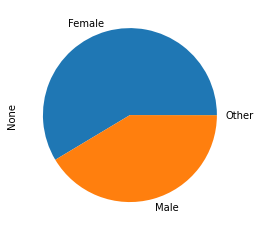

In [24]:
stroke_df.groupby('gender').size().plot(kind='pie')


In [29]:
stroke_df.loc[stroke_df['gender']=='Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


#### Age

#### Hypertension

#### Heart Disease

#### Marital Status

#### Work Type

#### Residence Type

#### Average Glucoze Level

#### Body Mass Index

#### Smoking Status

### The label: Stroke

## Data Cleaning

### Work Type

### Body Mass Index

### Smoking Status

## Random code

TODO: delete this section

In [5]:
stroke_df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
stroke_df.work_type.value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [7]:
stroke_df.age.map(lambda a: 1 if a >= 16 else 0).value_counts()

1    4366
0     744
Name: age, dtype: int64

In [8]:
stroke_df[stroke_df["age"]<16][stroke_df["work_type"]!="children"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
251,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,Unknown,0
253,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
284,26325,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0
410,54975,Male,7.0,0,0,No,Self-employed,Rural,64.06,18.9,Unknown,0
455,7351,Male,13.0,0,0,No,Private,Urban,92.14,23.2,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4709,41930,Male,15.0,0,0,No,Private,Rural,144.15,24.1,never smoked,0
4806,69723,Male,15.0,0,0,No,Private,Urban,137.27,19.3,never smoked,0
4903,56629,Female,14.0,0,0,No,Private,Rural,83.56,33.1,Unknown,0
4923,72186,Female,15.0,0,0,No,Private,Rural,82.19,40.5,never smoked,0
